In this post, we compute numeric values of the apparent stiffness introduced in [this post](../20210509-What_is_homogenization-05). Our goal is to find the solution to the general problem depicted below.

![The problem considered here](../What_is_homogenization-files/uniaxial_tension.png){width=60%}

We use a numeric approach that is akin to the finite element method. More precisely, we minimize the total potential energy of the spring with respect to the nodal displacements.

This time, we will use the [Julia programming language](https://julialang.org/).

In [1]:
using DelimitedFiles
using LinearAlgebra
using Plots
using Test

We first define a function that returns the stiffness matrix ox a single spring, according to [this post](../20201125-On_the_stiffness_matrix_of_a_linear_spring).

In [2]:
#| output: false
"""spring_stiffness_matrix(k, nx, ny)

Return the stiffness matrix of the spring with stiffness `k` and direction `(nx, ny)`.

The direction must be a unit vector (`nx² + ny² == 1`).

The degrees of freedom of the spring are ordered as follows:

1. horizontal displacement of node 1,
2. vertical displacement of node 1,
3. horizontal displacement of node 2,
4. vertical displacement of node 2.
"""
function spring_stiffness_matrix(k, nx, ny)
    kxx = k * nx * nx
    kyy = k * ny * ny
    kxy = k * nx * ny
    return [
        kxx kxy -kxx -kxy;
        kxy kyy -kxy -kyy;
        -kxx -kxy kxx kxy;
        -kxy -kyy kxy kyy]
end

spring_stiffness_matrix

We then define a structure that holds the description of the mesh. See [this post](../20210509-What_is_homogenization-05) for a description of the various symbols. Note that for the sake of simplicity, it is assumed that the number of cells is identical in both directions.

In [3]:
#| output: false
struct SpringMesh
    χx::Float64
    χy::Float64
    θ::Float64
    ncells::Int
    ndofs::Int
    SpringMesh(χx, χy, θ, ncells) = new(χx, χy, θ, ncells, 2 * (ncells+1)^2)
end

We define a function that computes the linear index of the node located at `(i⋅Δx, j⋅Δy)`. It would probably have been better to use [CartesianIndices](https://julialang.org/blog/2016/02/iteration/) for this purpose.

In [4]:
#| output: false
"""node_at(i, j, mesh)

Return the linear indnex of the node located at `(i, j)` in the mesh.

Note that `i` and `j` are zero-based, while the returned index in one-based.
"""
function node_at(i, j, mesh)
    (mesh.ncells+1)*j+i+1
end

node_at

To assemble the global stiffness matrix, we add block-wise the element stiffness matrix of each spring.

In [5]:
#| output: false
"""
add_spring_stiffness_matrix!(K, i1, j1, i2, j2, mesh, Ke)

Add to the global stiffness matrix `K` the element stiffness matrix `Ke`.

The spring connects nodes `(i1, j1)` and `(i2, j2)` (0-based indices).
"""
function add_spring_stiffness_matrix!(K, i1, j1, i2, j2, mesh, Ke)
    n1 = node_at(i1, j1, mesh)
    n2 = node_at(i2, j2, mesh)
    index = [2n1-1, 2n1, 2n2-1, 2n2]
    for i = 1:4
        for j = 1:4
            K[index[i], index[j]] += Ke[i, j]
        end
    end
end

add_spring_stiffness_matrix!

In [6]:
#| output: false
"""Return the stiffness matrix"""
function global_stiffness_matrix(mesh)
    K = zeros(mesh.ndofs, mesh.ndofs)
    c = cos(mesh.θ)
    s = sin(mesh.θ)
    K_h = spring_stiffness_matrix(mesh.χx, 1., 0.)
    K_v = spring_stiffness_matrix(mesh.χy, 0., 1.)
    K_d1 = spring_stiffness_matrix(1., c, s)
    K_d2 = spring_stiffness_matrix(1., -c, s)
    for i = 0:mesh.ncells
        for j = 0:mesh.ncells
            if i < mesh.ncells
                add_spring_stiffness_matrix!(K, i, j, i + 1, j, mesh, K_h)
            end
            if j < mesh.ncells
                add_spring_stiffness_matrix!(K, i, j, i, j + 1, mesh, K_v)
            end
            if (i < mesh.ncells) && (j < mesh.ncells)
                add_spring_stiffness_matrix!(K, i, j, i + 1, j + 1, mesh, K_d1)
                add_spring_stiffness_matrix!(K, i + 1, j, i, j + 1, mesh, K_d2)
            end
        end
    end
    return K
end

global_stiffness_matrix

The forces are applied only on the left and right boundaries. Assembly of the vector of nodal forces is done below.

In [7]:
#| output: false
"""nodal_forces(mesh)

Return the vector of nodal forces.

The total force applied on each side is 1.
"""
function nodal_forces(mesh)
    F = zeros(mesh.ndofs)
    f = 1. / mesh.ncells
    for j=1:mesh.ncells-1
        F[2 * node_at(0, j, mesh)-1] = -f
        F[2 * node_at(mesh.ncells, j, mesh)-1] = f
    end
    F[2 * node_at(0, 0, mesh)-1] = -0.5 * f
    F[2 * node_at(0, mesh.ncells, mesh)-1] = -0.5 * f
    F[2 * node_at(mesh.ncells, 0, mesh)-1] = 0.5 * f
    F[2 * node_at(mesh.ncells, mesh.ncells, mesh)-1] = 0.5 * f
    return F        
end

nodal_forces

We need to account for the boundary conditions that will prevent rigid body motion. We first define a general function that modifies the linear system to account for a *fixed* dof.

In [8]:
#| output: false
"""apply_bc!(K, F, fixed_dof, mesh)

Modify the stiffness matrix and vector of nodal forces to account for a fixed dof.
"""
function apply_bc!(K, F, fixed_dof, mesh)
    for dof = 1:mesh.ndofs
        K[fixed_dof, dof] = 0.
        K[dof, fixed_dof] = 0.
    end
    K[fixed_dof, fixed_dof] = 1.
    F[fixed_dof] = 0.
end

apply_bc!

The above function is then used to pin the lower-left corner and prevent vertical displacements of the lower-right corner as well as horizontal displacements of the upper-left corner.

In [9]:
#| output: false
function apply_bcs!(K, F, mesh)
    n0 = node_at(0, 0, mesh)
    apply_bc!(K, F, 2n0-1, mesh)
    apply_bc!(K, F, 2n0, mesh)
    
    n1 = node_at(mesh.ncells, 0, mesh)
    apply_bc!(K, F, 2n1, mesh)
    
    n2 = node_at(0, mesh.ncells, mesh)
    apply_bc!(K, F, 2n2-1, mesh)
end

apply_bcs! (generic function with 1 method)

Finally, the apparent stiffness is computed according to [this post]({filename}20210509-What_is_homogenization-05.md).

In [10]:
#| output: false
function apparent_stiffness(mesh)
    K = global_stiffness_matrix(mesh)
    F = nodal_forces(mesh)
    apply_bcs!(K, F, mesh)
    u = K\F
    elongation = 0.
    for j = 0:mesh.ncells
        left = 2 * node_at(0, j, mesh)-1
        right = 2 * node_at(mesh.ncells, j, mesh)-1
        weight = (j == 0) || (j == mesh.ncells) ? 0.5 : 1.0
        elongation += weight * (u[right] - u[left])
    end
    elongation /= mesh.ncells
    return 1. / elongation
end

apparent_stiffness (generic function with 1 method)

We use the symbolic expressions derived in [this post]({filename}20210512-Symbolic_analysis_of_a_spring_mesh.md) to test our implementation.

In [11]:
actual_stiffness(χ, n) = apparent_stiffness(SpringMesh(χ, χ, π/4, n))

effective_stiffness(χ) = χ*(χ+2)/(χ+1)
expected_stiffness_1x1(χ) = 4χ*(χ+1)/(2χ+1)
expected_stiffness_2x2(χ) = 8χ*(1+χ)*(2+χ)/(2χ+3)/(3χ+2)
expected_stiffness_3x3(χ) = 144χ*(χ+1)*(4*χ^4+24χ^3+41χ^2+24χ+4)/(480χ^5+2888χ^4+5616χ^3+4771χ^2+1800χ+236)

@testset "Apparent stiffness" begin
    χ = 2.0 .^ LinRange(-7, 7, 13)

    @test actual_stiffness.(χ, 1) ≈ expected_stiffness_1x1.(χ)
    @test actual_stiffness.(χ, 2) ≈ expected_stiffness_2x2.(χ)
    @test actual_stiffness.(χ, 3) ≈ expected_stiffness_3x3.(χ)
end;

Test Summary:      | Pass  Total  Time
Apparent stiffness |    3      3  1.4s


We then are ready to produce the figures that were used in [this post](../20210509-What_is_homogenization-05).

In [12]:
#| output: false
χ = 2.
χx = χ
χy = χ
θ = π / 4.
npoints = 7
ncells = 1 .<< (0:(npoints-1))
A_app = zeros(npoints)
for i = 1:npoints
    print("$(ncells[i]), ")
    mesh = SpringMesh(χx, χy, θ, ncells[i])
    A_app[i] = apparent_stiffness(mesh)
    println(A_app[i])
end

1, 4.8
2, 3.4285714285714275
4, 3.0300228871509005
8, 2.861937928085502
16, 2.7748131542266363
32, 2.7256259160694416
64, 2.698019760598089


In [13]:
#| output: false
Ax = cot(θ)*(1+cos(2θ)+χx)
Ay = tan(θ)*(1-cos(2θ)+χy)
Axy = sin(2θ)

A_eff = Ax - Axy^2 / Ay

2.6666666666666674

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


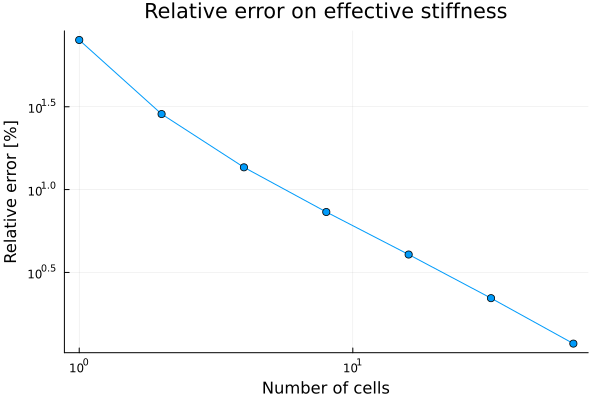

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


In [14]:
#| output: false
err = (A_app[:] .- A_eff) / A_eff
plot(ncells, 100*err, 
     axis=:log,
     marker=:circle, 
     label="", 
     xlabel="Number of cells", 
     ylabel="Relative error [%]", 
     title="Relative error on effective stiffness")

In [15]:
#| output: false
dir = joinpath("..", "What_is_homogenization-files")
basename = "apparent_stiffness_vs_number_of_cells"
savefig(joinpath(dir, basename * ".png"))
# savefig(basename * ".pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


"/home/sbrisard/Git/sbrisard.github.io/quarto/posts/What_is_homogenization-files/apparent_stiffness_vs_number_of_cells.png"

In [16]:
#| output: false
open(joinpath(dir, basename * ".csv"), "w") do io
    write(io, "# Apparent, uniaxial stiffness vs. number of cells\n")
    write(io, "# chi_x = $χx\n")
    write(io, "# chi_y = $χy\n")
    write(io, "# theta = $θ rad\n")
    writedlm(io, [ncells A_app], ",")
end

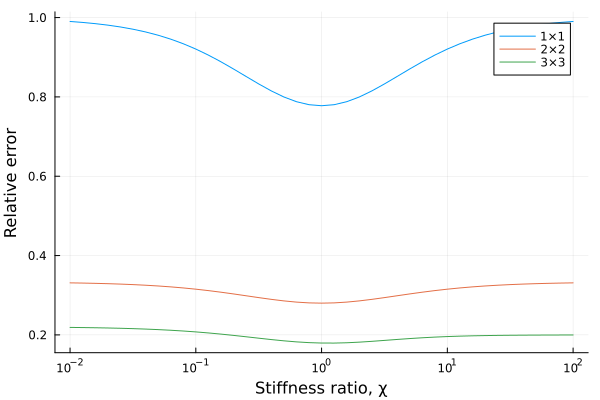

In [17]:
#| output: false
χ = 10.0 .^ LinRange(-2, 2, 41)
eff = effective_stiffness.(χ)
plot(χ, (expected_stiffness_1x1.(χ).-eff)./eff, label="1×1", 
     xaxis=:log, xlabel="Stiffness ratio, χ", ylabel="Relative error")
plot!(χ, (expected_stiffness_2x2.(χ).-eff)./eff, label="2×2")
plot!(χ, (expected_stiffness_3x3.(χ).-eff)./eff, label="3×3")

In [18]:
#| output: false
basename = "apparent_stiffness_vs_chi"
savefig(joinpath(dir, basename * ".png"))

"/home/sbrisard/Git/sbrisard.github.io/quarto/posts/What_is_homogenization-files/apparent_stiffness_vs_chi.png"